<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/Human_Image_Segmentation_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 5.4 MB/s 
     |████████████████████████████████| 376 kB 42.7 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=f0f6b91c1cade7b6fc4ee9f47ea04129a1a63ff90588d3f101d4a6041dc02e20
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=5482ecf578fc44cb429c24ed0b809ac68fe25d875290b723ce20d0e273dcc2de
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-q11hmqo2
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-q11hmqo2
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (3/3), done.


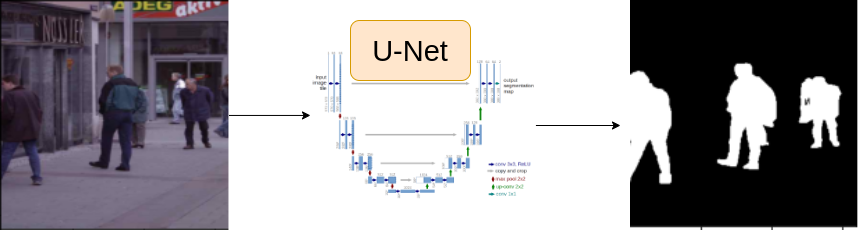

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
#importing the necessary libraries
import torch
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import helper
from tqdm import tqdm # will help us to track the progress
from sklearn.model_selection import train_test_split#will help us to split train and test data.

# Task : 2 Setup Configurations

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
#Now we will define all the necessary constants for this project work
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'
Learning_rate=0.003
IMAGE_SIZE=320
BATCH_SIZE=8
Encoder='timm-efficientnet-b0'
Weights='imagenet'

In [39]:
#Now reading from csv file
dataframe=pd.read_csv(CSV_FILE)
dataframe.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [40]:
#Now we will visualize a random image by reading it
index=dataframe.iloc[3]

image_path=index.images
mask_path=index.masks
#Now reading image
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#Now reading mask
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

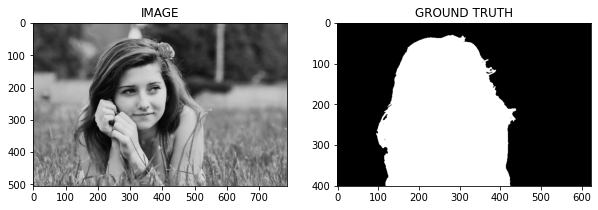

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image,cmap='gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [44]:
#Now splitting train and test data frame
train_df,test_df=train_test_split(dataframe,test_size=0.20,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [45]:
import albumentations as album 
#Now creating augmentation function for trainind data
def train_augment():
  #return album.
  return album.Compose(
      [
      album.Resize(IMAGE_SIZE,IMAGE_SIZE),
      album.HorizontalFlip(p=0.5),
      album.VerticalFlip(p=0.5)
      ]
  )
def valid_augment():
  return album.Compose(
      [
       album.Resize(IMAGE_SIZE,IMAGE_SIZE)
      ]
  )


# Task 4 : Create Custom Dataset 

In [46]:
#Now importing torch modules to create a custom dataset
from torch.utils.data.dataset import Dataset

In [47]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    #Return the size of set
    return len(self.df)
  def __getitem__(self, index):
    row=self.df.iloc[index]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

    #adding extra dimensions
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

      #Now doing channel shaping for converting to tensor
      #(h,w,c) will become (c,h,w)
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

      #Now we are converting image to tensor
    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)
    return image,mask

In [48]:
#Now finally creating our custom dataset
trainset=SegmentationDataset(train_df,train_augment())
validset=SegmentationDataset(test_df,valid_augment())

In [49]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


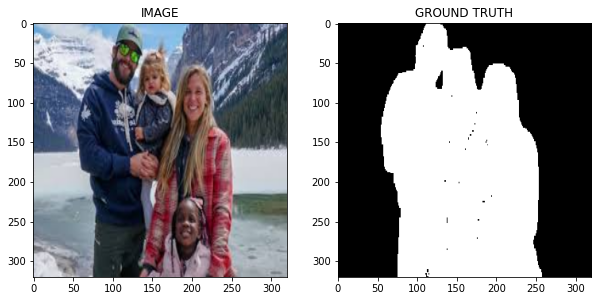

In [50]:
#now we want to visualize the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
index=2
image,mask=trainset[index]      
ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap='gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap ='gray')

# Task 5 : Load dataset into batches

In [51]:
#Now we will divide the whole dataset in batches
from torch.utils.data.dataloader import DataLoader

In [52]:
train_dataloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [53]:
print(f"Number of Batches in Train Loader {len(train_dataloader)}")
print(f"Number of Batches in Test Loader {len(valid_dataloader)}")

Number of Batches in Train Loader 29
Number of Batches in Test Loader 8


In [54]:
#Now just seeing the first batch
for image,mask in train_dataloader:
  break
print(f"One batch Image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch Image shape: torch.Size([8, 3, 320, 320])
One batch mask shape: torch.Size([8, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [55]:
#Now importing libraries necessary for creating segmentation model
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
torch.cuda.empty_cache()

In [56]:
#Now creating segmentation models class
class SegmentationModel(nn.Module):
  #Now creating our beloved initializer
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.UnetPlusPlus(
        encoder_name='resnet34',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None

    )
  def forward(self,images,masks=None):
    #This will perform training work
    #First make prediction
    logits=self.arc(images)
    if masks!= None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2
    
    return logits


In [57]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

# Task 7 : Create Train and Validation Function 

In [58]:
#Now creating a training function
def train_functiond(dataloader,model,optimizer):
  model.train()
  #Now loss 
  total_loss=0
  for img,mask in dataloader:
    images=img.to(DEVICE)
    masks=mask.to(DEVICE)
    #First define optimizer
    optimizer.zero_grad()
    logits,loss=model(images,masks)
    #Now perform backprop
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  return total_loss/len(dataloader)

In [59]:
#Now defining a evaluating function
def eval_functiond(dataloader,model):
  model.train()
  #Now loss 
  total_loss=0
  for img,mask in dataloader:
    images=img.to(DEVICE)
    masks=mask.to(DEVICE)
    #finding loss
    logits,loss=model(images,masks)
    total_loss+=loss.item()
  return total_loss/len(dataloader)

# Task 8 : Train Model

In [60]:
#Now defining optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=Learning_rate)

In [62]:
#Now running training
best_valid_loss=np.Inf
for i in range(50):
  train_loss=train_functiond(train_dataloader,model,optimizer)
  eval_loss=eval_functiond(valid_dataloader,model)
  if best_valid_loss>eval_loss:
    torch.save(model.state_dict(),"Best_model.pt")
    print("Model saved")
    best_valid_loss=eval_loss
  print(f"Epoch {i+1} Train Loss {train_loss} Validation Loss {eval_loss}")

Model saved
Epoch 1 Train Loss 0.12481663504551196 Validation Loss 0.33403804525732994
Model saved
Epoch 2 Train Loss 0.11522086170212976 Validation Loss 0.30665680952370167
Model saved
Epoch 3 Train Loss 0.10754815309212126 Validation Loss 0.2742782458662987
Epoch 4 Train Loss 0.10874077960334975 Validation Loss 0.36756218038499355
Epoch 5 Train Loss 0.13205920339658342 Validation Loss 0.38153623789548874
Epoch 6 Train Loss 0.16002952384537664 Validation Loss 0.2932813195511699
Epoch 7 Train Loss 0.1178819786371856 Validation Loss 0.31046673096716404
Epoch 8 Train Loss 0.09953752211455641 Validation Loss 0.32586100697517395
Epoch 9 Train Loss 0.13307217431479487 Validation Loss 0.31942319869995117
Epoch 10 Train Loss 0.1771064156602169 Validation Loss 0.4444430526345968
Epoch 11 Train Loss 0.275845173104056 Validation Loss 0.3644269909709692
Epoch 12 Train Loss 0.21543364149743113 Validation Loss 0.28044033236801624
Epoch 13 Train Loss 0.16540763989604754 Validation Loss 0.32977947033

# Task 9 : Inference

In [63]:
import helper

In [68]:
index=5
image,mask=validset[index]
#Now loading the model
model.load_state_dict(torch.load('/content/Best_model.pt'))
#Now predicting
logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

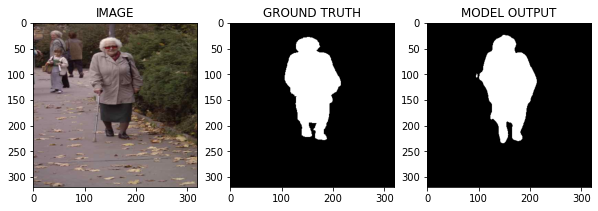

In [69]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))